In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [2]:
# Project Idea: predict crowdness of the subway every hour
# factors to consider 
# weather - more subway at rainy day 
# season? 
# which hour - more people in rush hour 
# 7am-10am / 11am-2pm / 4pm-8pm 
# weekend / late night, early morning
# deep learning - consider weather / day / hour
# flask, html - simple website in which if i select a specific station, it prints out the expected crowdness


In [3]:
df = pd.read_csv('mta_data_2023.csv')
df.head()

,transit_timestamp,transit_mode,station_complex_id,station_complex,borough,payment_method,fare_class_category,ridership,transfers,latitude,longitude,georeference
0,2023-01-01T00:00:00.000,subway,294,238 St (1),Bronx,omny,OMNY - Full Fare,5.0,0.0,40.884666,-73.900870,POINT (-73.90087 40.884666)
1,2023-01-01T00:00:00.000,subway,56,Ocean Pkwy (Q),Brooklyn,omny,OMNY - Full Fare,8.0,0.0,40.576313,-73.968500,POINT (-73.9685 40.576313)
2,2023-01-01T00:00:00.000,subway,434,"3 Av-149 St (2,5)",Bronx,metrocard,Metrocard - Unlimited 7-Day,12.0,0.0,40.816110,-73.917755,POINT (-73.917755 40.81611)
3,2023-01-01T00:00:00.000,subway,147,175 St (A),Manhattan,metrocard,Metrocard - Fair Fare,2.0,0.0,40.847390,-73.939705,POINT (-73.939705 40.84739)
4,2023-01-01T00:00:00.000,subway,85,"75 St-Elderts Ln (J,Z)",Queens,metrocard,Metrocard - Unlimited 7-Day,1.0,0.0,40.691322,-73.867140,POINT (-73.86714 40.691322)


In [4]:
# no null value 
df.isnull().sum()

transit_timestamp      0
transit_mode           0
station_complex_id     0
station_complex        0
borough                0
payment_method         0
fare_class_category    0
ridership              0
transfers              0
latitude               0
longitude              0
georeference           0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25585413 entries, 0 to 25585412
Data columns (total 12 columns):
 #   Column               Dtype  
---  ------               -----  
 0   transit_timestamp    object 
 1   transit_mode         object 
 2   station_complex_id   object 
 3   station_complex      object 
 4   borough              object 
 5   payment_method       object 
 6   fare_class_category  object 
 7   ridership            float64
 8   transfers            float64
 9   latitude             float64
 10  longitude            float64
 11  georeference         object 
dtypes: float64(4), object(8)
memory usage: 2.3+ GB


In [6]:
df = df.rename(columns = {
    "transit_timestamp" : "transaction_time",
    "transit_mode" : "subway_type",
    "ridership" : "entry_per_hour",
    "station_complex" : "station",
    "station_complex_id" : "station_id"
})

In [7]:
# Check if the data is saved until December 31st
df['transaction_time'] = pd.to_datetime(df['transaction_time'])
df['transaction_time'].max()

Timestamp('2023-12-31 23:00:00')

In [8]:
# stations with most rows
df['station'].value_counts().head(5)

station
Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)      76107
74-Broadway (7)/Jackson Hts-Roosevelt Av (E,F,M,R)    75261
Atlantic Av-Barclays Ctr (B,D,N,Q,R,2,3,4,5)          75217
Grand Central-42 St (S,4,5,6,7)                       74530
34 St-Penn Station (1,2,3)                            73889
Name: count, dtype: int64

In [9]:
# max five used stations 
top_50 = df.groupby('station')['entry_per_hour'].sum().sort_values(ascending = False).head(50)
top_50_stations = top_50.index.tolist()
df_50 = df[df['station'].isin(top_50_stations)].reset_index(drop = True)
df_50.head()

,transaction_time,subway_type,station_id,station,borough,payment_method,fare_class_category,entry_per_hour,transfers,latitude,longitude,georeference
0,2023-01-01,subway,9,"57 St-7 Av (N,Q,R,W)",Manhattan,metrocard,Metrocard - Unlimited 30-Day,93.0,0.0,40.764664,-73.980660,POINT (-73.98066 40.764664)
1,2023-01-01,subway,617,"Atlantic Av-Barclays Ctr (B,D,N,Q,R,2,3,4,5)",Brooklyn,omny,OMNY - Full Fare,197.0,0.0,40.684460,-73.976890,POINT (-73.97689 40.68446)
2,2023-01-01,subway,604,"161 St-Yankee Stadium (B,D,4)",Bronx,omny,OMNY - Full Fare,24.0,0.0,40.827995,-73.925650,POINT (-73.92565 40.827995)
3,2023-01-01,subway,471,34 St-Hudson Yards (7),Manhattan,metrocard,Metrocard - Unlimited 7-Day,44.0,0.0,40.755882,-74.001910,POINT (-74.00191 40.755882)
4,2023-01-01,subway,612,"Lexington Av-53 St (E,M)/51 St (6)",Manhattan,metrocard,Metrocard - Full Fare,116.0,2.0,40.757553,-73.969055,POINT (-73.969055 40.757553)


In [10]:
import folium
import seaborn as sns 
train_routes = df_50[['station', 'borough', 'latitude', 'longitude']].drop_duplicates(subset = ['station'])
train_routes = train_routes.rename(columns = {'station' : 'Station Name',
                                              'borough' : 'Borough',
                                              'longitude' : 'Long',
                                              'latitude' : 'Lat'})

borough_colors = {
    'Manhattan': '#0039A6',  
    'Brooklyn':  '#FF6319',  
    'Queens':    '#00933C',  
    'Bronx':     '#EE352E',  
    'Staten Island': '#A7A9AC' 
}

nyc_map = folium.Map(location=[40.730610, -73.935242], zoom_start=11)

for index, row in train_routes.iterrows():

    boro = row['Borough']
    color = borough_colors.get(boro, '#000000')
    
    folium.CircleMarker(
        location=[row['Lat'], row['Long']],
        radius=5,
        color=color,        
        fill=True,
        fill_color=color,  
        fill_opacity=0.7,
        popup=f"{row['Station Name']} ({boro})",
        tooltip=row['Station Name']
    ).add_to(nyc_map)

nyc_map

/var/folders/8q/3bk4mhcd2l38k0_tbmtbbsv80000gn/T/ipykernel_13615/1914557546.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'entry_per_hour', y = 'station', data = total_50, palette = 'viridis')


Text(0, 0.5, 'Station')

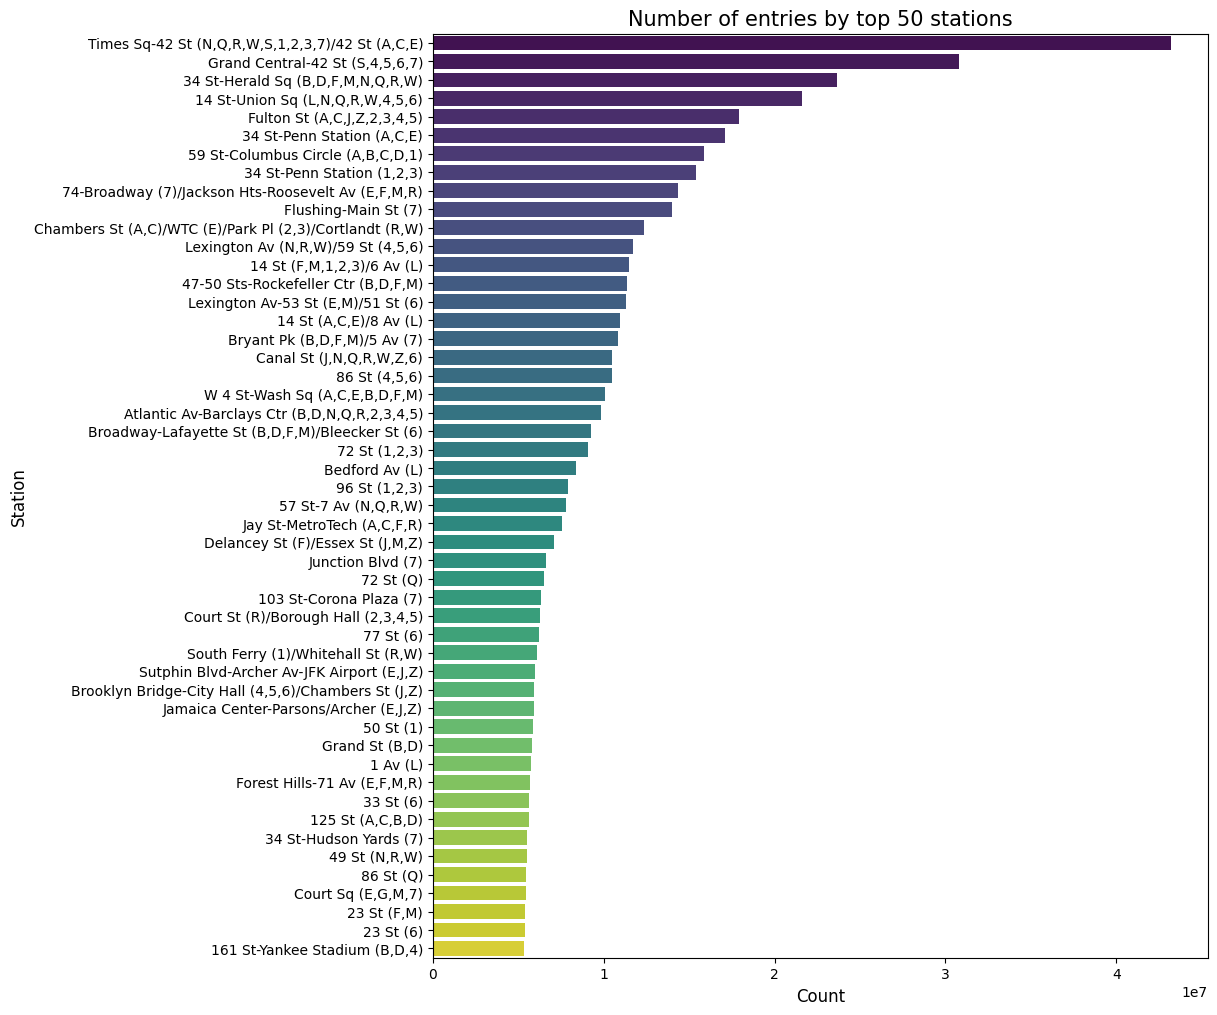

In [11]:
# simple bar graph
total_50 = df_50.groupby('station')['entry_per_hour'].sum().reset_index()
total_50 = total_50.sort_values('entry_per_hour', ascending = False)

fig, ax = plt.subplots(1, 1, figsize = (10, 12))
sns.barplot(x = 'entry_per_hour', y = 'station', data = total_50, palette = 'viridis')
ax.set_title('Number of entries by top 50 stations', fontsize = 15)
ax.set_xlabel('Count', fontsize = 12)
ax.set_ylabel('Station', fontsize = 12)

In [12]:
import datetime
temp = df_50[(df_50['transaction_time'].dt.date == datetime.date(2023, 9, 22)) & (df_50['station'] == '23 St (6)')]
temp['transaction_time'].unique()

<DatetimeArray>
['2023-09-22 00:00:00', '2023-09-22 01:00:00', '2023-09-22 02:00:00',
 '2023-09-22 03:00:00', '2023-09-22 04:00:00', '2023-09-22 05:00:00',
 '2023-09-22 06:00:00', '2023-09-22 07:00:00', '2023-09-22 08:00:00',
 '2023-09-22 09:00:00', '2023-09-22 10:00:00', '2023-09-22 11:00:00',
 '2023-09-22 12:00:00', '2023-09-22 13:00:00', '2023-09-22 14:00:00',
 '2023-09-22 15:00:00', '2023-09-22 16:00:00', '2023-09-22 17:00:00',
 '2023-09-22 18:00:00', '2023-09-22 19:00:00', '2023-09-22 20:00:00',
 '2023-09-22 21:00:00', '2023-09-22 22:00:00', '2023-09-22 23:00:00']
Length: 24, dtype: datetime64[ns]

In [15]:
clean_50 = df_50.groupby(['station', 'transaction_time', 'borough'])['entry_per_hour'].sum().reset_index()
clean_50.head()

,station,transaction_time,borough,entry_per_hour
0,1 Av (L),2023-01-01 00:00:00,Manhattan,469.0
1,1 Av (L),2023-01-01 01:00:00,Manhattan,707.0
2,1 Av (L),2023-01-01 02:00:00,Manhattan,448.0
3,1 Av (L),2023-01-01 03:00:00,Manhattan,255.0
4,1 Av (L),2023-01-01 04:00:00,Manhattan,150.0


In [18]:
# filled the missing hours to 0
start_date = clean_50['transaction_time'].min()
end_date =clean_50['transaction_time'].max()
full_hour_range = pd.date_range(start = start_date, end = end_date, freq = 'H')

stations = clean_50['station'].unique()
full_index = pd.MultiIndex.from_product(
    [stations, full_hour_range],
    names = ['station', 'transaction_time']
)

df_indexed = clean_50.set_index(['station', 'transaction_time'])
df_fillhr = df_indexed.reindex(full_index, fill_value = 0).reset_index()

# fill borough 
borough_map = clean_50.groupby('station')['borough'].first()
df_fillhr['borough'] = df_fillhr['station'].map(borough_map)

print(len(df_fillhr))
print(df_fillhr.isnull().sum())
df_fillhr[df_fillhr['entry_per_hour'] == 0]


438000
station             0
transaction_time    0
borough             0
entry_per_hour      0
dtype: int64


/var/folders/8q/3bk4mhcd2l38k0_tbmtbbsv80000gn/T/ipykernel_13615/843578035.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_hour_range = pd.date_range(start = start_date, end = end_date, freq = 'H')


,station,transaction_time,borough,entry_per_hour
313,1 Av (L),2023-01-14 01:00:00,Manhattan,0.0
314,1 Av (L),2023-01-14 02:00:00,Manhattan,0.0
330,1 Av (L),2023-01-14 18:00:00,Manhattan,0.0
335,1 Av (L),2023-01-14 23:00:00,Manhattan,0.0
344,1 Av (L),2023-01-15 08:00:00,Manhattan,0.0
...,...,...,...,...
395882,"Lexington Av-53 St (E,M)/51 St (6)",2023-03-12 02:00:00,Manhattan,0.0
404642,"South Ferry (1)/Whitehall St (R,W)",2023-03-12 02:00:00,Manhattan,0.0
413402,"Sutphin Blvd-Archer Av-JFK Airport (E,J,Z)",2023-03-12 02:00:00,Queens,0.0
422162,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",2023-03-12 02:00:00,Manhattan,0.0


In [30]:
# create new columns of hour, days of week, month, is holiday, is weekend tag
df_fillhr['hour'] = df_fillhr['transaction_time'].dt.hour
df_fillhr['weekday'] = df_fillhr['transaction_time'].dt.dayofweek
df_fillhr['month'] = df_fillhr['transaction_time'].dt.month

# check if its weekend (more people use subway at weekend)
df_fillhr['isweekend'] = df_fillhr['weekday'].apply(lambda x: 1 if x >= 5 else 0)

# check if its in rush hour (more people use subway at rush hour)
def rush_hour(x):
    if x >= 6 and x <= 10:
        return 1
    elif x >= 16 and x <= 20:
        return 1
    else:
        return 0

df_fillhr['is_rush_hr'] = df_fillhr['hour'].apply(rush_hour)
df_fillhr
    

,station,transaction_time,borough,entry_per_hour,hour,weekday,month,isweekend,is_rush_hr
0,1 Av (L),2023-01-01 00:00:00,Manhattan,469.0,0,6,1,1,0
1,1 Av (L),2023-01-01 01:00:00,Manhattan,707.0,1,6,1,1,0
2,1 Av (L),2023-01-01 02:00:00,Manhattan,448.0,2,6,1,1,0
3,1 Av (L),2023-01-01 03:00:00,Manhattan,255.0,3,6,1,1,0
4,1 Av (L),2023-01-01 04:00:00,Manhattan,150.0,4,6,1,1,0
...,...,...,...,...,...,...,...,...,...
437995,"W 4 St-Wash Sq (A,C,E,B,D,F,M)",2023-12-31 19:00:00,Manhattan,1321.0,19,6,12,1,1
437996,"W 4 St-Wash Sq (A,C,E,B,D,F,M)",2023-12-31 20:00:00,Manhattan,1298.0,20,6,12,1,1
437997,"W 4 St-Wash Sq (A,C,E,B,D,F,M)",2023-12-31 21:00:00,Manhattan,1289.0,21,6,12,1,0
437998,"W 4 St-Wash Sq (A,C,E,B,D,F,M)",2023-12-31 22:00:00,Manhattan,1218.0,22,6,12,1,0


In [33]:
import holidays

ny_holiday = holidays.US(subdiv = 'NY', years = [2022, 2023, 2024])

def check_holiday(x):
    if x in ny_holiday:
        return 1
    else:
        return 0

df_fillhr['is_holiday'] = df_fillhr['transaction_time'].dt.date.apply(check_holiday)
sample_holiday = df_fillhr[df_fillhr['transaction_time'].dt.date.astype(str) == '2023-12-25']
sample_holiday

,station,transaction_time,borough,entry_per_hour,hour,weekday,month,isweekend,is_rush_hr,is_holiday
8592,1 Av (L),2023-12-25 00:00:00,Manhattan,45.0,0,0,12,0,0,1
8593,1 Av (L),2023-12-25 01:00:00,Manhattan,45.0,1,0,12,0,0,1
8594,1 Av (L),2023-12-25 02:00:00,Manhattan,17.0,2,0,12,0,0,1
8595,1 Av (L),2023-12-25 03:00:00,Manhattan,18.0,3,0,12,0,0,1
8596,1 Av (L),2023-12-25 04:00:00,Manhattan,18.0,4,0,12,0,0,1
...,...,...,...,...,...,...,...,...,...,...
437851,"W 4 St-Wash Sq (A,C,E,B,D,F,M)",2023-12-25 19:00:00,Manhattan,739.0,19,0,12,0,1,1
437852,"W 4 St-Wash Sq (A,C,E,B,D,F,M)",2023-12-25 20:00:00,Manhattan,764.0,20,0,12,0,1,1
437853,"W 4 St-Wash Sq (A,C,E,B,D,F,M)",2023-12-25 21:00:00,Manhattan,747.0,21,0,12,0,0,1
437854,"W 4 St-Wash Sq (A,C,E,B,D,F,M)",2023-12-25 22:00:00,Manhattan,608.0,22,0,12,0,0,1


In [36]:
df_fillhr.head()

,station,transaction_time,borough,entry_per_hour,hour,weekday,month,is_weekend,is_rush_hr,is_holiday
0,1 Av (L),2023-01-01 00:00:00,Manhattan,469.0,0,6,1,1,0,1
1,1 Av (L),2023-01-01 01:00:00,Manhattan,707.0,1,6,1,1,0,1
2,1 Av (L),2023-01-01 02:00:00,Manhattan,448.0,2,6,1,1,0,1
3,1 Av (L),2023-01-01 03:00:00,Manhattan,255.0,3,6,1,1,0,1
4,1 Av (L),2023-01-01 04:00:00,Manhattan,150.0,4,6,1,1,0,1


In [58]:
# lag feature - giving memory to take daily situation into account 
df_lag = df_fillhr.sort_values(by = ['transaction_time', 'station'])
# one hour ago 
df_lag['hr_lag'] = df_lag.groupby('station')['entry_per_hour'].shift(1)
# yesterday
df_lag['day_lag'] = df_lag.groupby('station')['entry_per_hour'].shift(24)
# week ago
df_lag['week_lag'] = df_lag.groupby('station')['entry_per_hour'].shift(168)

# drop the null values - its only 7 out of 365 days (1.9%)
df_cleaned = df_lag.dropna().copy()
df_cleaned.reset_index(inplace = True, drop = True)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429600 entries, 0 to 429599
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   station           429600 non-null  object        
 1   transaction_time  429600 non-null  datetime64[ns]
 2   borough           429600 non-null  object        
 3   entry_per_hour    429600 non-null  float64       
 4   hour              429600 non-null  int32         
 5   weekday           429600 non-null  int32         
 6   month             429600 non-null  int32         
 7   is_weekend        429600 non-null  int64         
 8   is_rush_hr        429600 non-null  int64         
 9   is_holiday        429600 non-null  int64         
 10  hr_lag            429600 non-null  float64       
 11  day_lag           429600 non-null  float64       
 12  week_lag          429600 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int32(3), int64(3), objec

In [59]:
# encoding 
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# label encoding - station
le_enc = LabelEncoder()
df_cleaned['station_enc'] = le_enc.fit_transform(df_cleaned['station'])

#save map
station_map = dict(zip(le_enc.transform(le_enc.classes_), le_enc.classes_))

# one hot encoding - borough
df_cleaned = pd.get_dummies(df_cleaned, columns = ['borough'], prefix = 'boro')
df_cleaned = df_cleaned.drop(['station', 'transaction_time'], axis = 1)

# scale the entry_per_hour
scaler = MinMaxScaler()
cols_to_scale = ['entry_per_hour', 'hr_lag', 'day_lag', 'week_lag']
df_cleaned[cols_to_scale] = scaler.fit_transform(df_cleaned[cols_to_scale])
df_cleaned = df_cleaned.astype(float)

print(df_cleaned.info())
df_cleaned.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429600 entries, 0 to 429599
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   entry_per_hour  429600 non-null  float64
 1   hour            429600 non-null  float64
 2   weekday         429600 non-null  float64
 3   month           429600 non-null  float64
 4   is_weekend      429600 non-null  float64
 5   is_rush_hr      429600 non-null  float64
 6   is_holiday      429600 non-null  float64
 7   hr_lag          429600 non-null  float64
 8   day_lag         429600 non-null  float64
 9   week_lag        429600 non-null  float64
 10  station_enc     429600 non-null  float64
 11  boro_Bronx      429600 non-null  float64
 12  boro_Brooklyn   429600 non-null  float64
 13  boro_Manhattan  429600 non-null  float64
 14  boro_Queens     429600 non-null  float64
dtypes: float64(15)
memory usage: 49.2 MB
None


,entry_per_hour,hour,weekday,month,is_weekend,is_rush_hr,is_holiday,hr_lag,day_lag,week_lag,station_enc,boro_Bronx,boro_Brooklyn,boro_Manhattan,boro_Queens
0,0.022164,0.0,6.0,1.0,1.0,0.0,0.0,0.035006,0.024841,0.023255,0.0,0.0,0.0,1.0,0.0
1,0.003273,0.0,6.0,1.0,1.0,0.0,0.0,0.006099,0.003520,0.006892,1.0,0.0,0.0,0.0,1.0
2,0.006049,0.0,6.0,1.0,1.0,0.0,0.0,0.011255,0.005900,0.010413,2.0,0.0,0.0,1.0,0.0
3,0.035998,0.0,6.0,1.0,1.0,0.0,0.0,0.051220,0.038328,0.047650,3.0,0.0,0.0,1.0,0.0
4,0.030643,0.0,6.0,1.0,1.0,0.0,0.0,0.045319,0.031733,0.034113,4.0,0.0,0.0,1.0,0.0


In [61]:
import joblib
import pickle

# 1. Save your Cleaned Data
print("Saving Data...")
df_cleaned.to_csv('nyc_subway_ml_data.csv', index=False)

# 2. Save your Scaler ]
print("Saving Scaler...")
joblib.dump(scaler, 'scaler.pkl')

# 3. Save your Station Map
print("Saving Station Map...")
with open('station_map.pkl', 'wb') as f:
    pickle.dump(station_map, f)

print("All files saved successfully!")

Saving Data...
Saving Scaler...
Saving Station Map...
All files saved successfully!
